**Table of content**
1. OLS
2. Lasso
3. Gradient Boosting
4. Random Forest


In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.diagnostic import linear_reset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# **OLS**

In [4]:
df_raw = pd.read_excel("raw_data.xlsx")

df = df_raw[['nrOfConversations', 'no_of_matches', 'sum_app_opens', 'no_of_days',
             'swipe_likes', 'swipe_passes', 'ageFilterMin', 'ageFilterMax',
             'education', 'gender', 'interestedIn', 'instagram', 'spotify',
             'user_age']]

df['interestedIn'] = df.apply(lambda x: 1 if x['gender'] == x['interestedIn'] else 0, axis=1)
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'F' else 0)
df['education'] = df['education'].apply(lambda x: 1 if x == 'Has high school and/or college education' else 0)
df['instagram'] = df['instagram'].apply(lambda x: 1 if x == True else 0)
df['spotify'] = df['spotify'].apply(lambda x: 1 if x == True else 0)
df['swipe_picky'] = df['swipe_likes']/(df['swipe_likes'] + df['swipe_passes'])
df['age_pref'] = df.apply(lambda x: 1 if x['user_age'] - ((x['ageFilterMin'] + x['ageFilterMax']) / 2) < 0 else 0, axis=1)
df['age_pref_gender_interaction'] = df['age_pref'] * df['gender']

<ipython-input-4-b8e2637a2d5b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['interestedIn'] = df.apply(lambda x: 1 if x['gender'] == x['interestedIn'] else 0, axis=1)
<ipython-input-4-b8e2637a2d5b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender'] = df['gender'].apply(lambda x: 1 if x == 'F' else 0)
<ipython-input-4-b8e2637a2d5b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [27]:
# Define the regression formula
dependent_var = 'nrOfConversations'
independent_vars = [
    'no_of_matches', 'sum_app_opens', 'no_of_days', 'swipe_picky',
    'user_age', 'education', 'gender', 'interestedIn',
    'instagram', 'spotify', 'age_pref', 'age_pref_gender_interaction'
]
variables = [dependent_var] + independent_vars

# Summary statistics for the variables
print("\nSummary Statistics:")
summary_stats = df[variables].describe().transpose()
summary_stats['missing_values'] = df[variables].isnull().sum()
print(summary_stats)


Summary Statistics:
                             count         mean          std   min  \
nrOfConversations            978.0   288.570552   740.862368   0.0   
no_of_matches                978.0   670.283231  1659.914968   0.0   
sum_app_opens                978.0  5678.949898  9121.757938   2.0   
no_of_days                   978.0   404.645194   433.222499   1.0   
swipe_picky                  978.0     0.354061     0.264133   0.0   
user_age                     978.0    24.095092     7.576438  14.0   
education                    978.0     0.213701     0.410128   0.0   
gender                       978.0     0.132924     0.339667   0.0   
interestedIn                 978.0     0.033742     0.180658   0.0   
instagram                    978.0     0.240286     0.427476   0.0   
spotify                      978.0     0.389571     0.487902   0.0   
age_pref                     978.0     0.725971     0.446252   0.0   
age_pref_gender_interaction  978.0     0.128834     0.335188   0.0   


Kernel Density Estimation Plots:


<ipython-input-28-c27abeed97f2>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[var].dropna(), shade=True)
<ipython-input-28-c27abeed97f2>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[var].dropna(), shade=True)
<ipython-input-28-c27abeed97f2>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[var].dropna(), shade=True)
<ipython-input-28-c27abeed97f2>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[var].dropna(), shade=True)
<ipython-input-28-c27abeed97f2>:6: FutureWarning: 

`shade` 

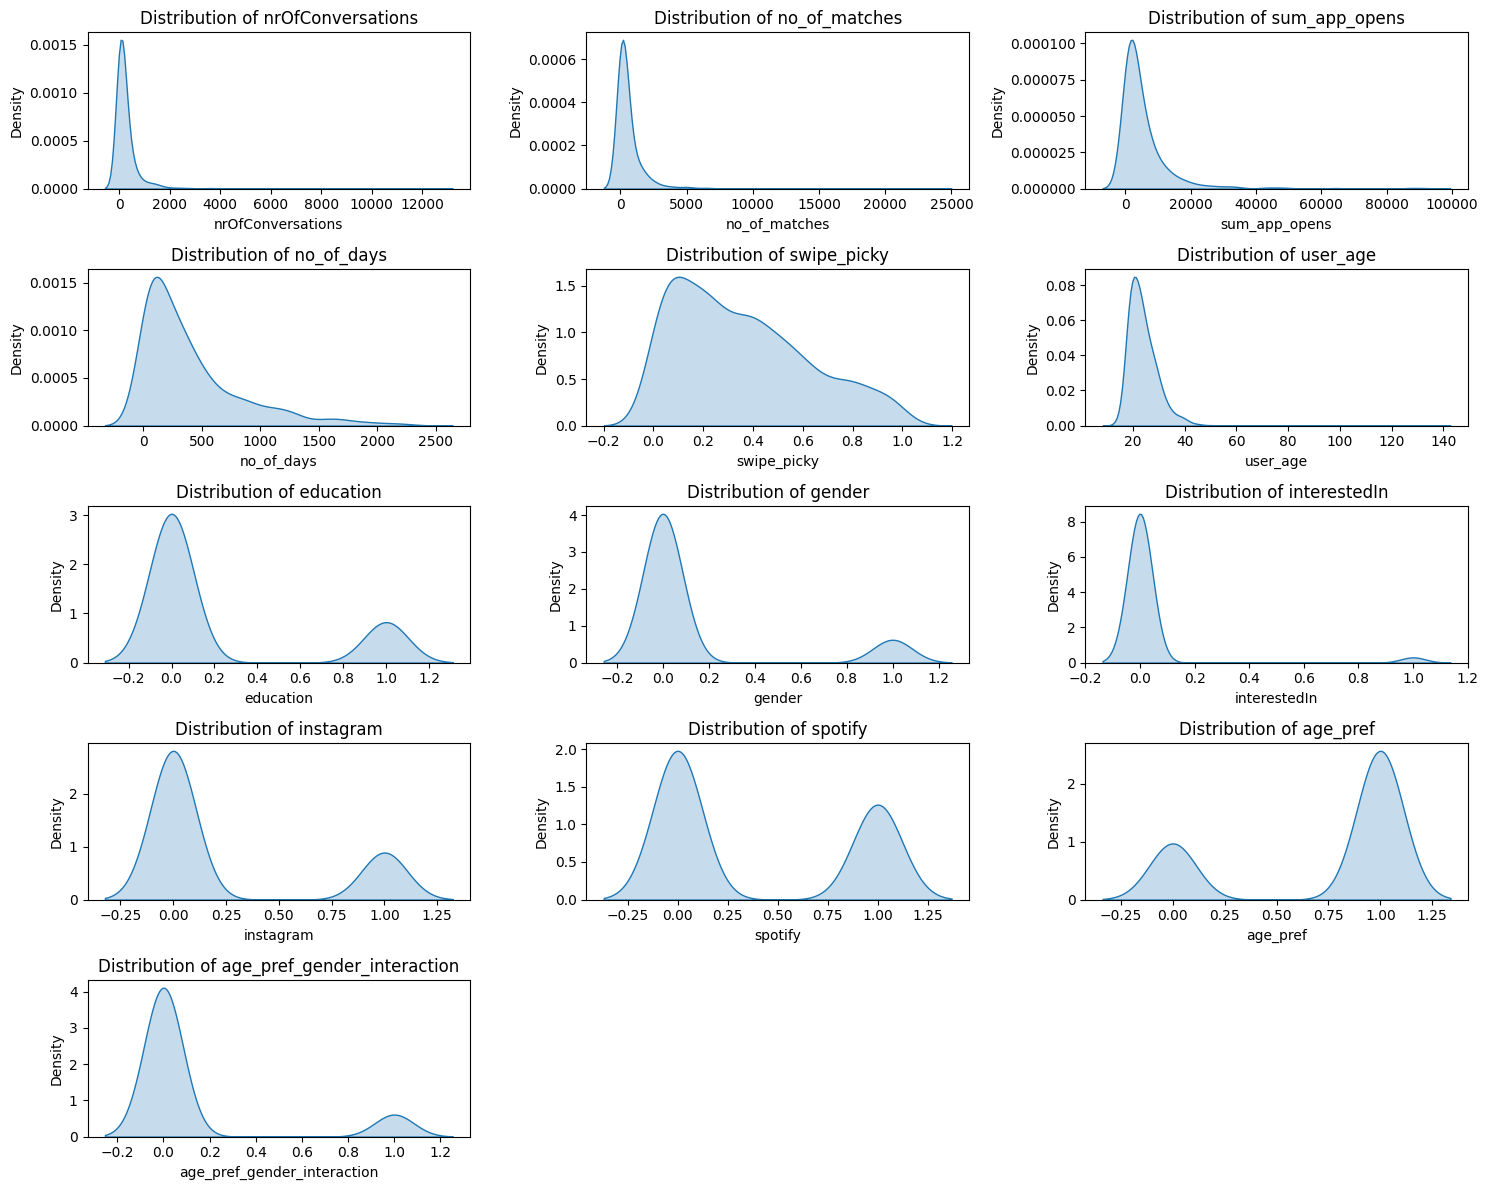

In [28]:
# Kernel density estimation plots for the variables
print("\nKernel Density Estimation Plots:")
plt.figure(figsize=(15, 12))
for i, var in enumerate(variables):
    plt.subplot((len(variables) // 3) + 1, 3, i + 1)
    sns.kdeplot(df[var].dropna(), shade=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
plt.tight_layout()
plt.show()

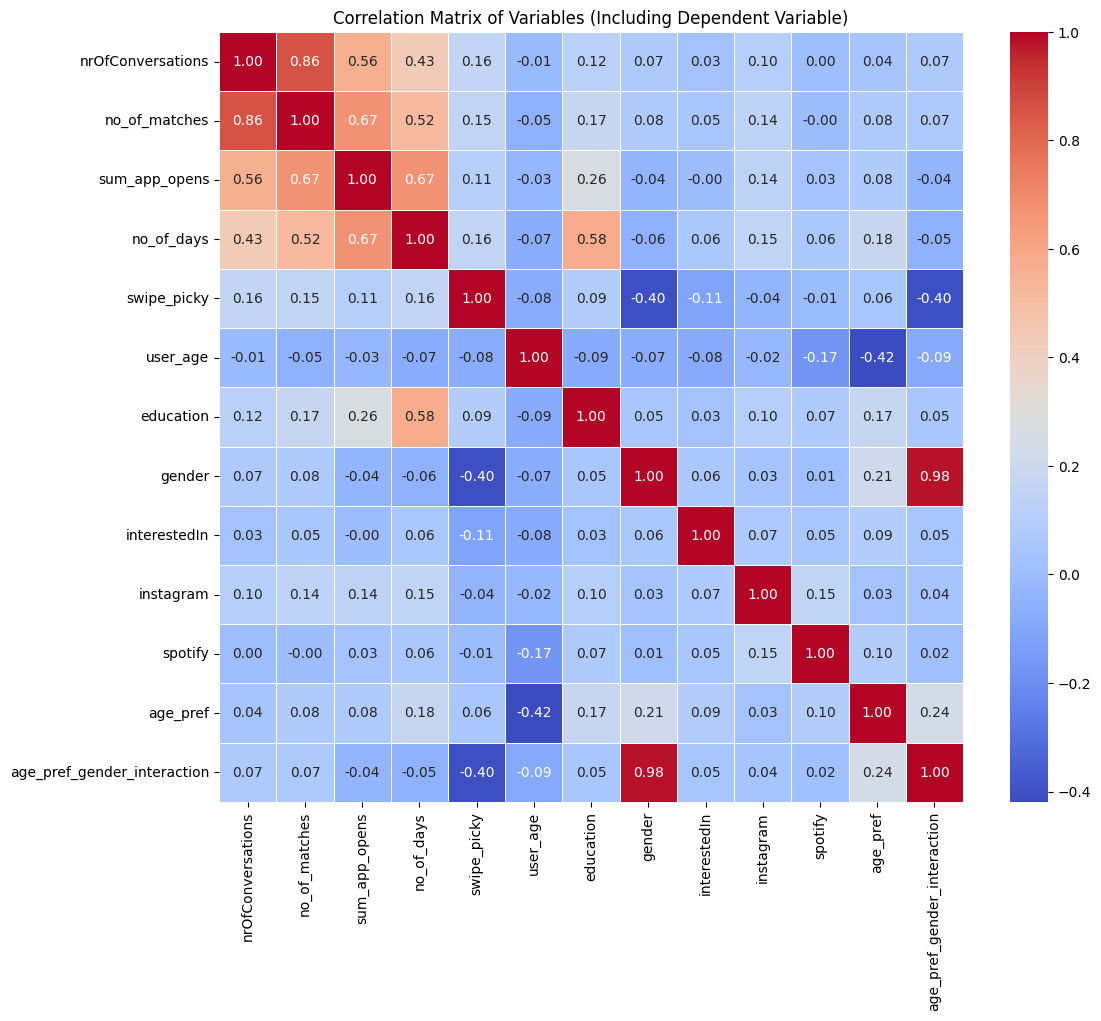

In [29]:
# Create correlation matrix with the dependent and independent variables
correlation_matrix = df[variables].corr()

# Plot the correlogram
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Variables (Including Dependent Variable)')
plt.show()

In [30]:
# Define the regression formula
formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"

# Run the OLS regression model
model = smf.ols(formula=formula, data=df).fit(cov_type='HC3')  # HC3 for heteroscedasticity-consistent standard errors

# Print summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      nrOfConversations   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     23.80
Date:                Sun, 12 Jan 2025   Prob (F-statistic):           6.74e-47
Time:                        10:56:57   Log-Likelihood:                -7193.9
No. Observations:                 978   AIC:                         1.441e+04
Df Residuals:                     965   BIC:                         1.448e+04
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [31]:
#Test for Heteroskedasticity (Breusch-Pagan Test)
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("\nBreusch-Pagan Test for Heteroskedasticity:")
print(lzip(labels, bp_test))


Breusch-Pagan Test for Heteroskedasticity:
[('Lagrange multiplier statistic', 565.6811460498657), ('p-value', 2.2394702150465833e-113), ('f-value', 110.32770324640938), ('f p-value', 1.5056345873191262e-171)]


In [32]:
#Test for Autocorrelation (Breusch-Godfrey Test)
bg_test = acorr_breusch_godfrey(model, nlags=1)
labels_bg = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("\nBreusch-Godfrey Test for Autocorrelation:")
print(lzip(labels_bg, bg_test))


Breusch-Godfrey Test for Autocorrelation:
[('Lagrange multiplier statistic', 0.39396087271743063), ('p-value', 0.5302247122623839), ('f-value', 0.3884778388217566), ('f p-value', 0.5332480324996354)]


In [33]:

#Multicollinearity Check (Variance Inflation Factor - VIF)
vif_data = pd.DataFrame()
vif_data["feature"] = independent_vars
vif_data["VIF"] = [variance_inflation_factor(model.model.exog, i) for i in range(1, len(model.model.exog_names))]
print("\nVariance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
                        feature        VIF
0                 no_of_matches   1.992497
1                 sum_app_opens   2.552012
2                    no_of_days   2.790626
3                   swipe_picky   1.325403
4                      user_age   1.256987
5                     education   1.617588
6                        gender  29.234647
7                  interestedIn   1.051129
8                     instagram   1.060707
9                       spotify   1.060016
10                     age_pref   1.350954
11  age_pref_gender_interaction  29.605603


In [34]:
#Ramsey RESET Test (Test for Functional Form)
reset_test = linear_reset(model)
print("\nRamsey RESET Test for Functional Form:")
print(f"F-statistic: {reset_test.statistic}, p-value: {reset_test.pvalue}")


Ramsey RESET Test for Functional Form:
F-statistic: 4.936814557942727, p-value: 0.08471968642793731


In [35]:
#Test for Omitted Variables (Ramsey RESET Test can also be used for this purpose)
print("\nTest for Omitted Variables (based on RESET test):")
print(f"F-statistic: {reset_test.statistic}, p-value: {reset_test.pvalue}")


Test for Omitted Variables (based on RESET test):
F-statistic: 4.936814557942727, p-value: 0.08471968642793731


# **Lasso**

In [15]:
df = df.dropna()

# Select explanatory and explained variables
X = df[['sum_app_opens', 'swipe_likes', 'swipe_passes',
        'education', 'gender', 'interestedIn', 'instagram', 'spotify',
        'user_age', 'age_pref', 'swipe_picky']]
y = df['nrOfConversations']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use LassoCV to automatically find the best alpha
lasso_cv = LassoCV(alphas=None, cv=5, random_state=42)  # alphas=None allows automatic selection of candidate values
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha value
best_alpha = lasso_cv.alpha_
print(f"Optimal Alpha: {best_alpha}")

# Make predictions
y_pred = lasso_cv.predict(X_test_scaled)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_cv.coef_})
print(coefficients)

Optimal Alpha: 16.081830285561526
Mean Squared Error: 263455.0170525272
R-squared Score: 0.5658363633208459
          Feature  Coefficient
0   sum_app_opens   229.063012
1     swipe_likes   219.671829
2    swipe_passes    -0.495260
3       education   -10.244157
4          gender   105.928058
5    interestedIn    19.048378
6       instagram     9.096410
7         spotify    -8.356845
8        user_age     0.000000
9        age_pref   -14.651935
10    swipe_picky    31.703222


Alpha: 0.001, MSE: 256937.0060, R-squared: 0.5766
Alpha: 0.001, MSE: 256937.0295, R-squared: 0.5766
Alpha: 0.001, MSE: 256937.0479, R-squared: 0.5766
Alpha: 0.002, MSE: 256937.0700, R-squared: 0.5766
Alpha: 0.002, MSE: 256937.0967, R-squared: 0.5766
Alpha: 0.003, MSE: 256937.1289, R-squared: 0.5766
Alpha: 0.003, MSE: 256937.1869, R-squared: 0.5766
Alpha: 0.004, MSE: 256937.2339, R-squared: 0.5766
Alpha: 0.004, MSE: 256937.2906, R-squared: 0.5766
Alpha: 0.005, MSE: 256937.3590, R-squared: 0.5766
Alpha: 0.007, MSE: 256937.4836, R-squared: 0.5766
Alpha: 0.008, MSE: 256937.5834, R-squared: 0.5766
Alpha: 0.010, MSE: 256937.7039, R-squared: 0.5766
Alpha: 0.012, MSE: 256937.9379, R-squared: 0.5766
Alpha: 0.014, MSE: 256938.1138, R-squared: 0.5766
Alpha: 0.017, MSE: 256938.3265, R-squared: 0.5766
Alpha: 0.020, MSE: 256938.5835, R-squared: 0.5766
Alpha: 0.024, MSE: 256939.0728, R-squared: 0.5766
Alpha: 0.029, MSE: 256939.4489, R-squared: 0.5766
Alpha: 0.036, MSE: 256939.9042, R-squared: 0.5766


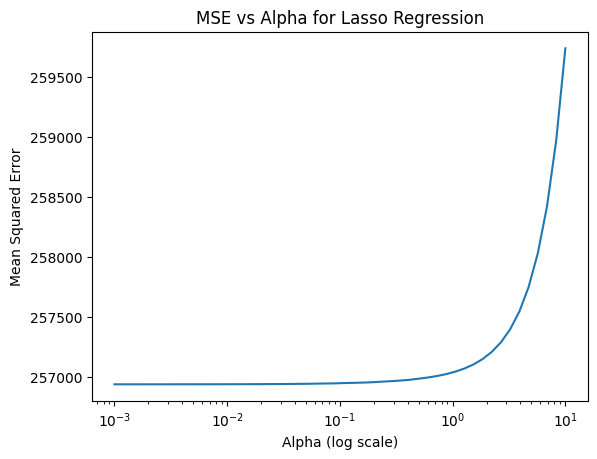

Important Features:           Feature  Coefficient
0   sum_app_opens   229.063012
1     swipe_likes   219.671829
2    swipe_passes    -0.495260
3       education   -10.244157
4          gender   105.928058
5    interestedIn    19.048378
6       instagram     9.096410
7         spotify    -8.356845
9        age_pref   -14.651935
10    swipe_picky    31.703222


In [19]:
######################## Tuning
alphas = np.logspace(-3, 1, 50)  # 50 values from 0.001 to 10
results = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train)
    y_pred = lasso.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((alpha, mse, r2))

# Display the results
for alpha, mse, r2 in results:
    print(f"Alpha: {alpha:.3f}, MSE: {mse:.4f}, R-squared: {r2:.4f}")

######################## Plotting
import matplotlib.pyplot as plt

alphas = [result[0] for result in results]
mses = [result[1] for result in results]

plt.plot(alphas, mses)
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha for Lasso Regression')
plt.show()

######################## Important features
non_zero_features = coefficients[coefficients['Coefficient'] != 0]
print("Important Features:", non_zero_features)

# **Gradient Boosting**

In [20]:
# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Fit the model
gbr.fit(X_train, y_train)

# Make predictions
y_pred_gbr = gbr.predict(X_test)

# Calculate performance metrics
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting - Mean Squared Error: {mse_gbr}")
print(f"Gradient Boosting - R-squared Score: {r2_gbr}")

# Feature importance
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': gbr.feature_importances_}).sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

Gradient Boosting - Mean Squared Error: 236655.85971727152
Gradient Boosting - R-squared Score: 0.6100003338490354
Feature Importances:
          Feature  Importance
0   sum_app_opens    0.533349
10    swipe_picky    0.178902
1     swipe_likes    0.126889
2    swipe_passes    0.053513
8        user_age    0.043072
4          gender    0.027239
6       instagram    0.014856
3       education    0.010642
9        age_pref    0.008609
5    interestedIn    0.002627
7         spotify    0.000303


In [21]:
######################## Hyperparameter Tuning for Gradient Boosting

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],   # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2], # Shrinks contribution of each tree
    'max_depth': [3, 4, 5],            # Maximum depth of each tree
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Tuned Gradient Boosting - Mean Squared Error: {mse_best}")
print(f"Tuned Gradient Boosting - R-squared Score: {r2_best}")

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Tuned Gradient Boosting - Mean Squared Error: 219967.47934679344
Tuned Gradient Boosting - R-squared Score: 0.6375021365969678


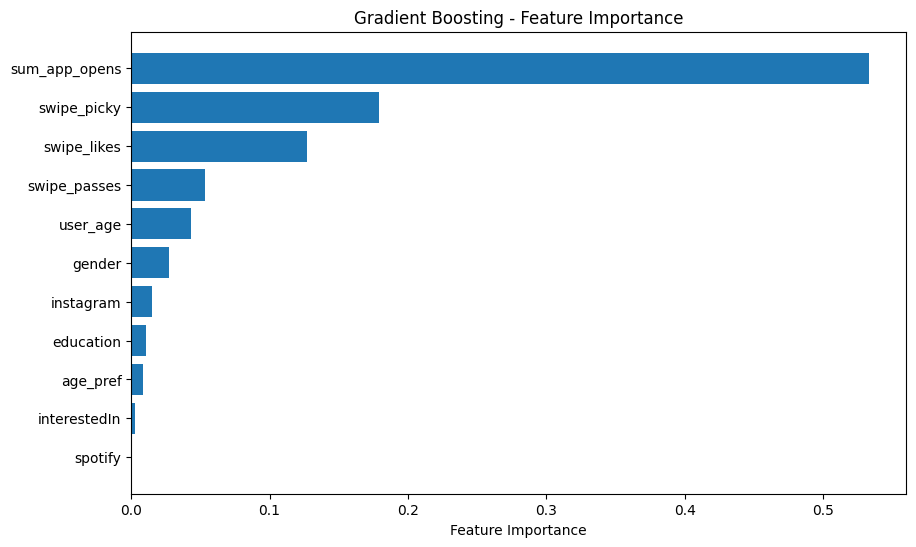

In [22]:
######################## Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting - Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# **Random Forest**

In [48]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Calculate performance metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R-squared Score: {r2_rf}")

# Feature importance
feature_importances_rf = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances_rf)

Random Forest - Mean Squared Error: 207504.30175326814
Random Forest - R-squared Score: 0.6580409692566025
Feature Importances:
          Feature  Importance
0   sum_app_opens    0.366851
1     swipe_likes    0.251005
10    swipe_picky    0.166162
8        user_age    0.065428
4          gender    0.049038
2    swipe_passes    0.043347
9        age_pref    0.028219
3       education    0.010630
6       instagram    0.008578
5    interestedIn    0.006301
7         spotify    0.004441


In [49]:
######################## Hyperparameter Tuning for Random Forest

# Define parameter distributions for RandomizedSearchCV
param_distributions_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

# Perform RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions_rf,
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1
)
random_search_rf.fit(X_train, y_train)

# Best parameters
best_params_rf = random_search_rf.best_params_
print(f"Best parameters for Random Forest: {best_params_rf}")

# Evaluate the best model
best_rf = random_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"Tuned Random Forest with RandomizedSearchCV - Mean Squared Error: {mse_best_rf}")
print(f"Tuned Random Forest with RandomizedSearchCV - R-squared Score: {r2_best_rf}")

Best parameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 25}
Tuned Random Forest with RandomizedSearchCV - Mean Squared Error: 260326.42829993318
Tuned Random Forest with RandomizedSearchCV - R-squared Score: 0.5709921560846214


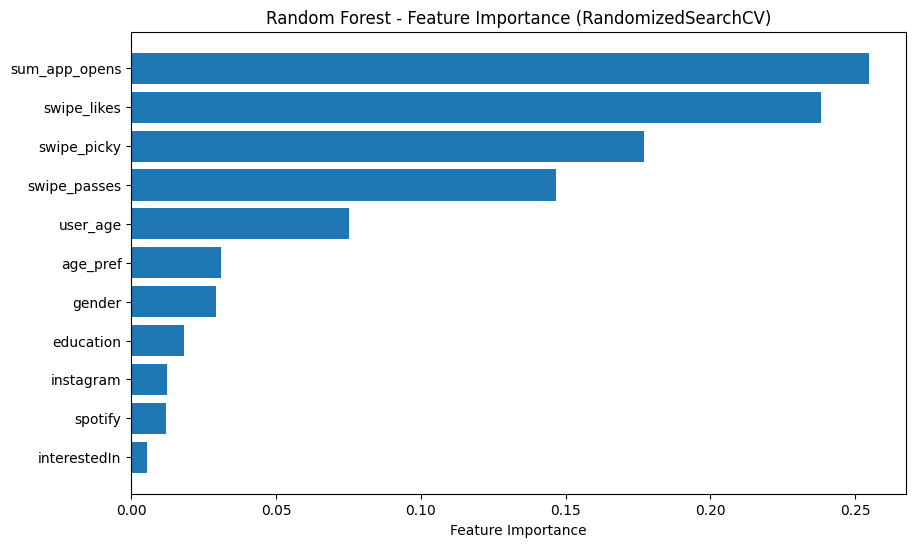

Baseline MSE: 207504.30175326814
Baseline R2: 0.6580409692566025
Tuned MSE: 260326.42829993318
Tuned R2: 0.5709921560846214


In [50]:
# Feature importance plot
feature_importances_rf = pd.DataFrame({'Feature': X.columns, 'Importance': best_rf.feature_importances_}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_rf['Feature'], feature_importances_rf['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance (RandomizedSearchCV)')
plt.gca().invert_yaxis()
plt.show()

# Baseline Random Forest
rf_baseline = RandomForestRegressor(random_state=42)
rf_baseline.fit(X_train, y_train)
y_pred_baseline = rf_baseline.predict(X_test)
print(f"Baseline MSE: {mean_squared_error(y_test, y_pred_baseline)}")
print(f"Baseline R2: {r2_score(y_test, y_pred_baseline)}")

# Best tuned model
print(f"Tuned MSE: {mean_squared_error(y_test, y_pred_best_rf)}")
print(f"Tuned R2: {r2_score(y_test, y_pred_best_rf)}")